# Monte Carlo integration

In this notebook I want to explore how I can do a Monte Carlo (MC) integration using a library.
I'm interested in a Markov Chain Monte Carlo (MCMC), using a Metropolis algorithm or a variation of it.

In the following I will investigate libraries and compute the simple integral of `x^2` from `0` to `2`.
We want to sample from `x/2` and estimate `2*x`. The expected result is `2.6666`

In [13]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image

In [2]:
num_warming_steps = 500
num_samples = 20000
estimate_fn = lambda x: 2. * x

## Tensorflow

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp

#### Set sampling distribution

I will use the triangular distribution

In [4]:
target_log_prob_fn = tfp.distributions.Triangular(low=0.0, high=2.0, peak=2.).log_prob

Verify how the log of the sampling distribution looks like beween `0` and `2`

<AxesSubplot:xlabel='x'>

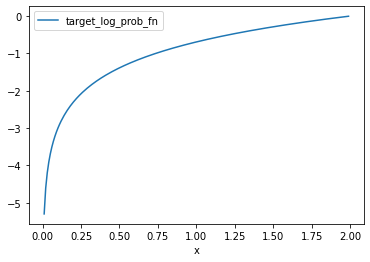

In [5]:
x = [_x for _x in np.arange(0., 2., 0.01)]
y = [target_log_prob_fn(_x).numpy() for _x in x]
pd.DataFrame({'x': x, 'target_log_prob_fn': y}).set_index('x').plot()

#### Set the kernel

I will use the simple `RandomWalkMetropolis` that does not use gradient.

In [6]:
kernel = tfp.mcmc.RandomWalkMetropolis(target_log_prob_fn=target_log_prob_fn)

#### Sample points

In [7]:
%%time

samples = tfp.mcmc.sample_chain(
  num_results=num_samples,
  current_state=tf.ones(1),
  kernel=kernel,
  num_burnin_steps=500,
  trace_fn=None)

CPU times: user 1min 13s, sys: 635 ms, total: 1min 14s
Wall time: 1min 16s


In [8]:
df = pd.DataFrame({'x': samples.numpy().reshape([num_samples])})
fig = px.histogram(df, x='x')
fig.write_image("images/mcmc_with_tensorflow.jpg")

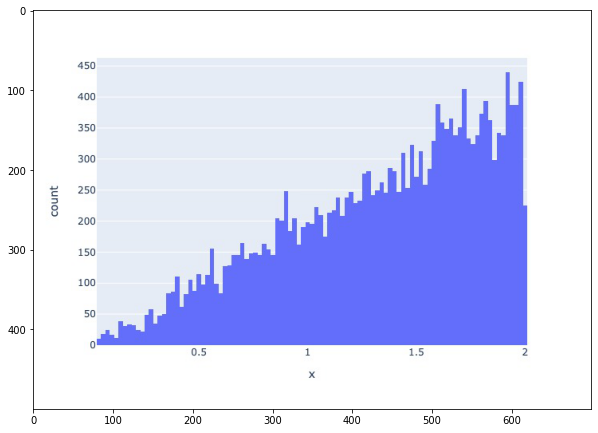

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('images/mcmc_with_tensorflow.jpg'))
plt.show()

#### Estimate integral

Finally we can estimate the integral by mapping the sampled points to the estimated function values.
For now I will ignore auto-correlation and estimate the error assuming uncorrelated samples.

In [10]:
values = [estimate_fn(x) for x in samples.numpy().reshape([num_samples])]

print(f'Integral = { tf.math.reduce_mean(values) } +- { tf.math.reduce_std(values)/np.sqrt(num_samples) }')

Integral = 2.6628134931318463 +- 0.006723373255593746


## Pymc3

In [11]:
import pymc3 as pm

#### Set the sampling function and sample

Here I cannot set the triangular distribution to have the middle point equal to the rightest point, so I approximate it.

In [12]:
%%time

with pm.Model() as model: # context management
    p = pm.Triangular('x', lower=0., c=1.9999999999, upper=2.)
    trace = pm.sample(draws=num_samples, start={'x': [1.]}, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 13.5 s, sys: 1.2 s, total: 14.7 s
Wall time: 19.5 s


In [17]:
df = pd.DataFrame({'x': trace['x']})
fig = px.histogram(df, x='x')
fig.write_image("images/mcmc_with_pymc3.jpg")

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('images/mcmc_with_pymc3.jpg'))
plt.show()

#### Estimate integral

Finally we can estimate the integral by mapping the sampled points to the estimated function values.
For now I will ignore auto-correlation and estimate the error assuming uncorrelated samples.

In [15]:
values = [estimate_fn(x) for x in trace['x']]

np.mean(values), np.std(values)/np.sqrt(100000)

(2.6583105809713485, 0.0029953849149606244)

## Conclusion

Even though tensorflow has been clearly outperformed by pymc3, I consider tensorflow a better choice because overall it seems to me as a more mature and flexible tool. Specific reasons:
* I didn't have any problem in setting the triangular distribution with the rightmost point equal to the middle one. This shows that tensorflow put more effort in considering corner cases.
* in tensorflow I had the choice of multiple algorithms for sampling and felt very much in control of what is going under the hoods
* in tensorflow there is the option of callback functions that could in principle allow me for a variety of customization of the algorithm